In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
from pathlib import Path
from collections import Counter

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
!unzip /content/dataset.zip -d /content/train

In [ ]:
!unzip /content/SmallTest.zip -d /content/test

In [ ]:
def load_usps():
    """USPs Digits dataset.

    The data of this dataset is a 3d numpy array vector with shape (224, 224, 3)
    containing 9298 224x224 RGB photos of handwritten digits, and the target is
    a 1d numpy integer array containing the label of the digit represented in
    the image.
    """
    dataset_path = _load('usps')

    df = _load_csv(dataset_path, 'data')
    X = _load_images(os.path.join(dataset_path, 'images'), df.image)
    y = df.label.values

    return Dataset(load_usps.__doc__, X, y, accuracy_score, 'image',
                   'classification', 'binary', stratify=True) 

# Data preprocessing

In [ ]:
data_dir = Path("./train/")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))

In [ ]:
images[:5]

['train/1-1_12.png',
 'train/10_1112.png',
 'train/10_1144.png',
 'train/10_1150.png',
 'train/10_12023.png']

In [ ]:
labels = []
for img in images:
  labels.append(img.split("_")[-1].split(".")[0])

In [ ]:
labels[:5]

['12', '1112', '1144', '1150', '12023']

In [ ]:
print(len(images), len(labels))

929 929


In [ ]:
characters = set(char for label in labels for char in label)

In [ ]:
characters

{'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'}

In [ ]:
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50

In [ ]:
max_length = max([len(label) for label in labels])
print(max_length)

5


# Split the data

In [ ]:

# Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

# Create dataset

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [ ]:
list(train_dataset.as_numpy_iterator())[0]

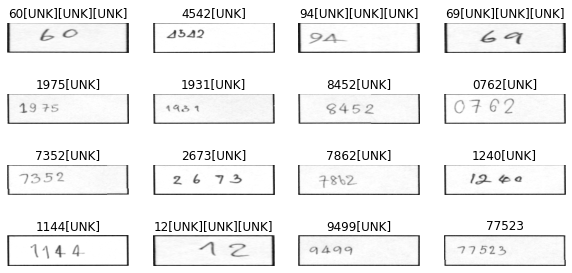

In [ ]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

# Model

In [ ]:

class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 25, 64)  18496       ['pool1[0][0]']       

# Training

In [ ]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/100
53/53 [==============================] - 9s 66ms/step - loss: 15.0834 - val_loss: 11.9796
Epoch 2/100
53/53 [==============================] - 2s 38ms/step - loss: 11.5746 - val_loss: 11.6631
Epoch 3/100
53/53 [==============================] - 2s 38ms/step - loss: 11.0300 - val_loss: 10.7496
Epoch 4/100
53/53 [==============================] - 2s 36ms/step - loss: 10.6448 - val_loss: 10.4428
Epoch 5/100
53/53 [==============================] - 2s 36ms/step - loss: 10.2966 - val_loss: 10.0275
Epoch 6/100
53/53 [==============================] - 2s 37ms/step - loss: 10.0710 - val_loss: 9.8606
Epoch 7/100
53/53 [==============================] - 2s 37ms/step - loss: 9.8734 - val_loss: 9.6082
Epoch 8/100
53/53 [==============================] - 2s 37ms/step - loss: 9.7550 - val_loss: 9.6744
Epoch 9/100
53/53 [==============================] - 2s 37ms/step - loss: 9.6793 - val_loss: 9.4661
Epoch 10/100
53/53 [==============================] - 2s 37ms/step - loss: 9.6141 - val_l

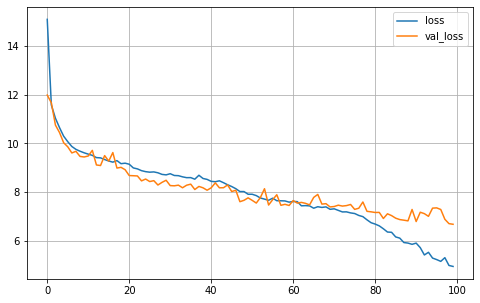

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    callbacks=[early_stopping],
)

Epoch 1/50
53/53 [==============================] - 2s 37ms/step - loss: 4.7104 - val_loss: 6.6029
Epoch 2/50
53/53 [==============================] - 2s 38ms/step - loss: 4.4304 - val_loss: 6.8587
Epoch 3/50
53/53 [==============================] - 2s 37ms/step - loss: 4.2032 - val_loss: 6.8883
Epoch 4/50
53/53 [==============================] - 2s 38ms/step - loss: 4.1084 - val_loss: 6.9217
Epoch 5/50
53/53 [==============================] - 2s 37ms/step - loss: 4.0754 - val_loss: 6.3633
Epoch 6/50
53/53 [==============================] - 2s 38ms/step - loss: 3.9064 - val_loss: 6.6007
Epoch 7/50
53/53 [==============================] - 2s 38ms/step - loss: 3.7065 - val_loss: 6.6231
Epoch 8/50
53/53 [==============================] - 2s 37ms/step - loss: 3.7262 - val_loss: 6.4804
Epoch 9/50
53/53 [==============================] - 2s 37ms/step - loss: 3.6596 - val_loss: 6.4461
Epoch 10/50
53/53 [==============================] - 2s 37ms/step - loss: 3.3987 - val_loss: 6.5472
Epoch 11/

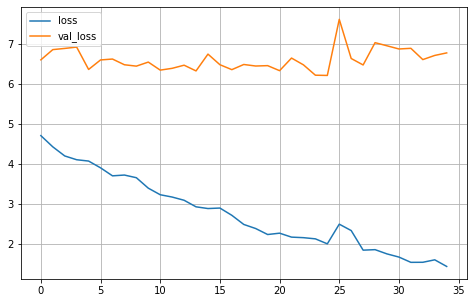

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

# Predict

In [ ]:

# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
#prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

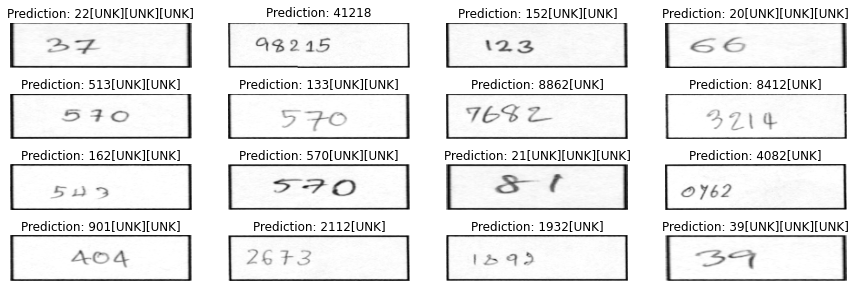

In [ ]:
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

# Test data

In [ ]:
data_dir_test = Path("./test/")
images_test = sorted(list(map(str, list(data_dir_test.glob("*.png")))))

In [ ]:
images_test[0]

'test/086ccb440e8b74f5f2a7713e0a07bd36.png'

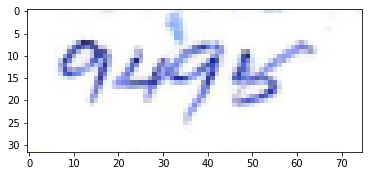

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(images_test[0])
imgplot = plt.imshow(img)
plt.show()

In [ ]:
a = encode_single_sample(images_test[0], '9495')

In [ ]:
a = encode_single_sample(images[5], labels[5])

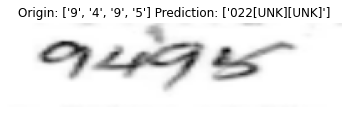

In [ ]:
preds = prediction_model.predict(np.array(a['image']).reshape([1,200,50,1]))
pred_texts = decode_batch_predictions(preds)

orig_texts = []
for label in a['label']:
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    orig_texts.append(label)

img = (a['image'] * 255).numpy().astype(np.uint8)
img = img.reshape([200,50])
img = img.T
title = f"Origin: {str(orig_texts)} Prediction: {pred_texts}"
plt.imshow(img, cmap="gray")
plt.title(title)
plt.axis("off")
plt.show()

In [ ]:
def encode_image(img_path):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    return {"image": img}

In [ ]:
pred_result = []
for i in images_test:
  a = encode_image(i)
  preds = prediction_model.predict(np.array(a['image']).reshape([1,200,50,1]))
  pred_texts = decode_batch_predictions(preds)
  pred_result.append(pred_texts)

In [ ]:
data = []
for i in range(32,48):
  a = encode_image(images_test[i])
  data.append(a)

In [ ]:
data[0]['image']

In [ ]:
pred_exam = pred_result[32:48]

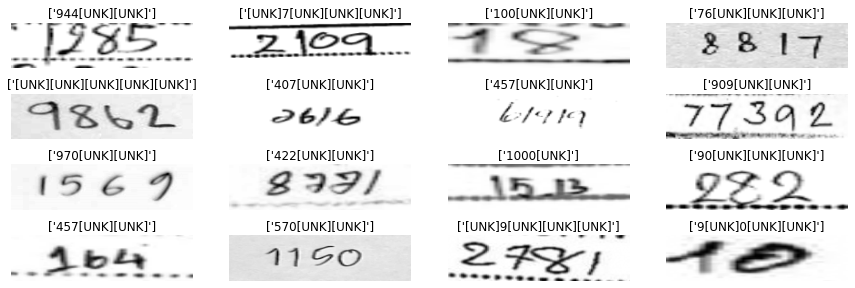

In [ ]:
_, ax = plt.subplots(4, 4, figsize=(15, 5))
for i in range(16):
    img = (data[i]['image'] * 255).numpy().astype("uint8")
    ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
    ax[i // 4, i % 4].set_title(pred_exam[i])
    ax[i // 4, i % 4].axis("off")
plt.show()

# Something to test

In [ ]:
file_names = os.listdir("/content/numbers")

In [ ]:
img = tf.io.read_file("/content/numbers/00700310666e007443e58fb5361bda30.jpg")
img = tf.io.decode_jpeg(img, channels=1)
img = tf.image.convert_image_dtype(img, tf.float32)
img = tf.image.resize(img, [50, 200])
img = tf.transpose(img, perm=[1, 0, 2])

In [ ]:
img

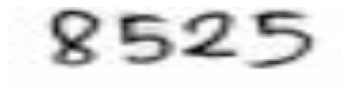

In [ ]:
img1 = (img * 255).numpy().astype("uint8")
plt.imshow(img1[:, :, 0].T, cmap="gray")
plt.axis("off")
plt.show()

## .bmp to .jpg

In [ ]:
bmp_file_name = os.listdir("/content/bmp_file")

In [ ]:
from pathlib import Path

data_dir = Path("./bmp_file/")
images_bmp = sorted(list(map(str, list(data_dir.glob("*.bmp")))))

In [ ]:
images_bmp[:5]

['bmp_file/is01001.bmp',
 'bmp_file/is01002.bmp',
 'bmp_file/is01003.bmp',
 'bmp_file/is01004.bmp',
 'bmp_file/is01005.bmp']

In [ ]:
from PIL import Image
c = 1
for i in images_bmp:
  img = Image.open(i)
  save_file_dir = '/content/bmp_to_png/pic{}.png'.format(c)
  c = c + 1
  img.save(save_file_dir, 'png')

## Extract box number from image

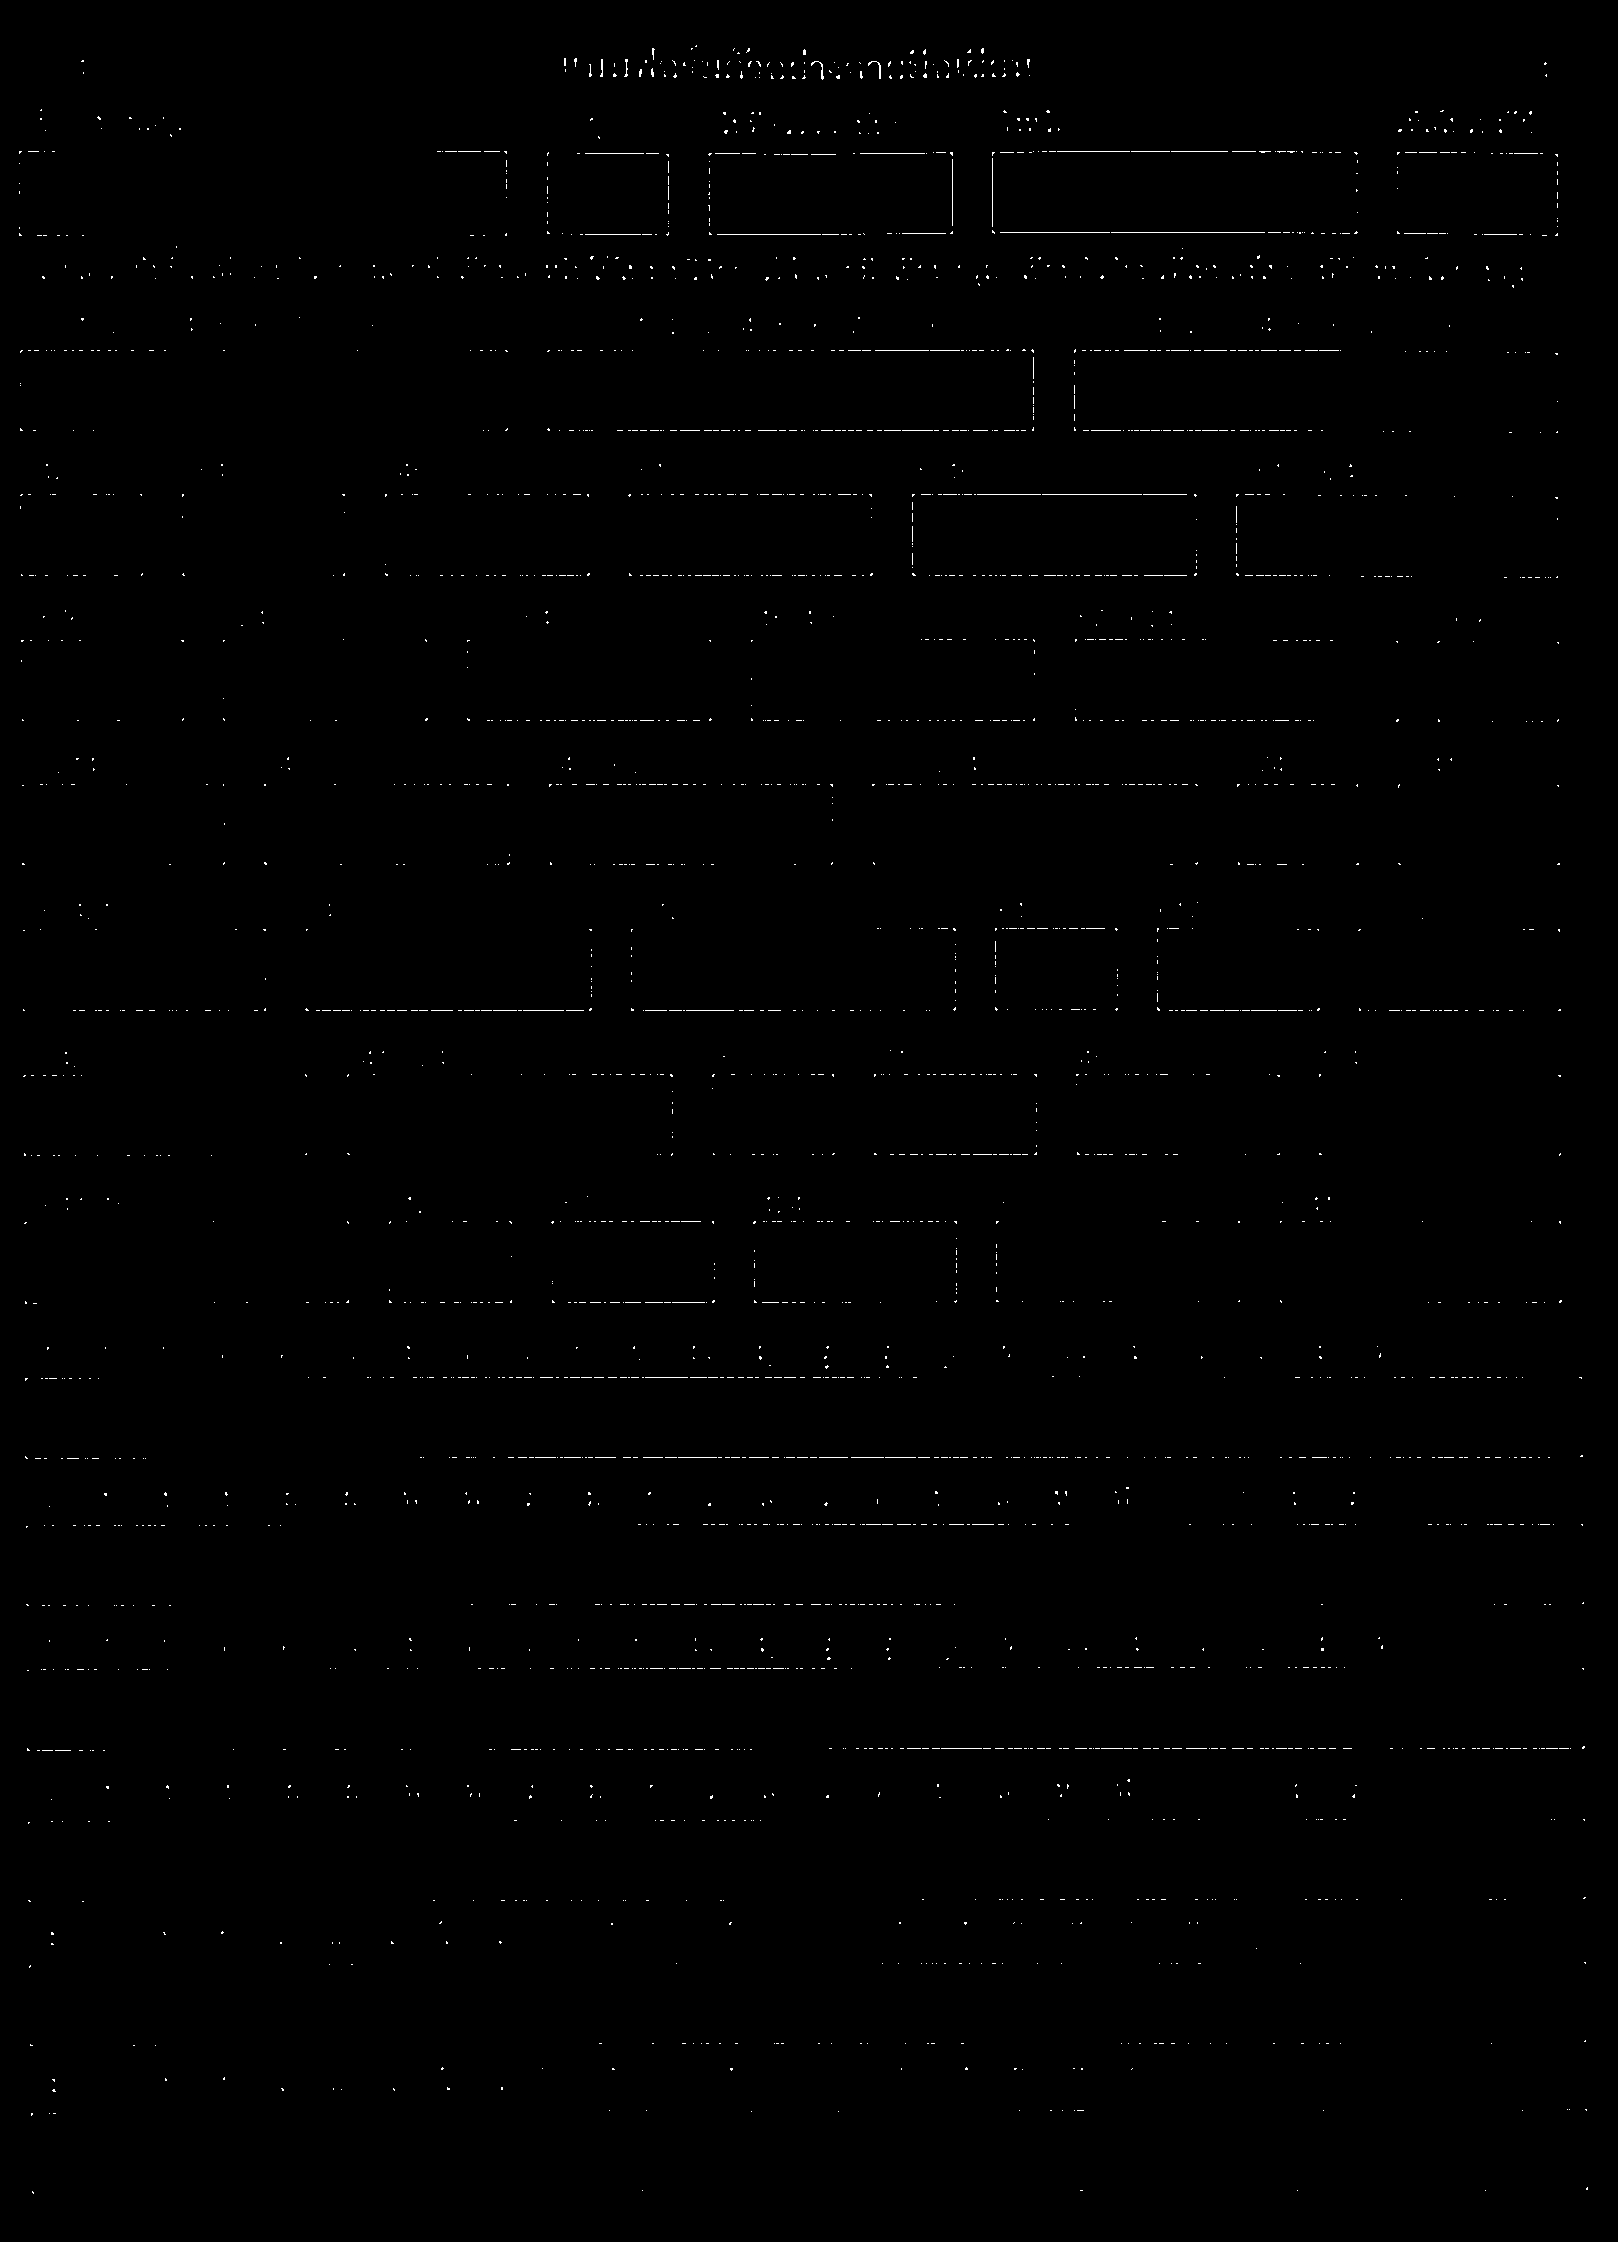

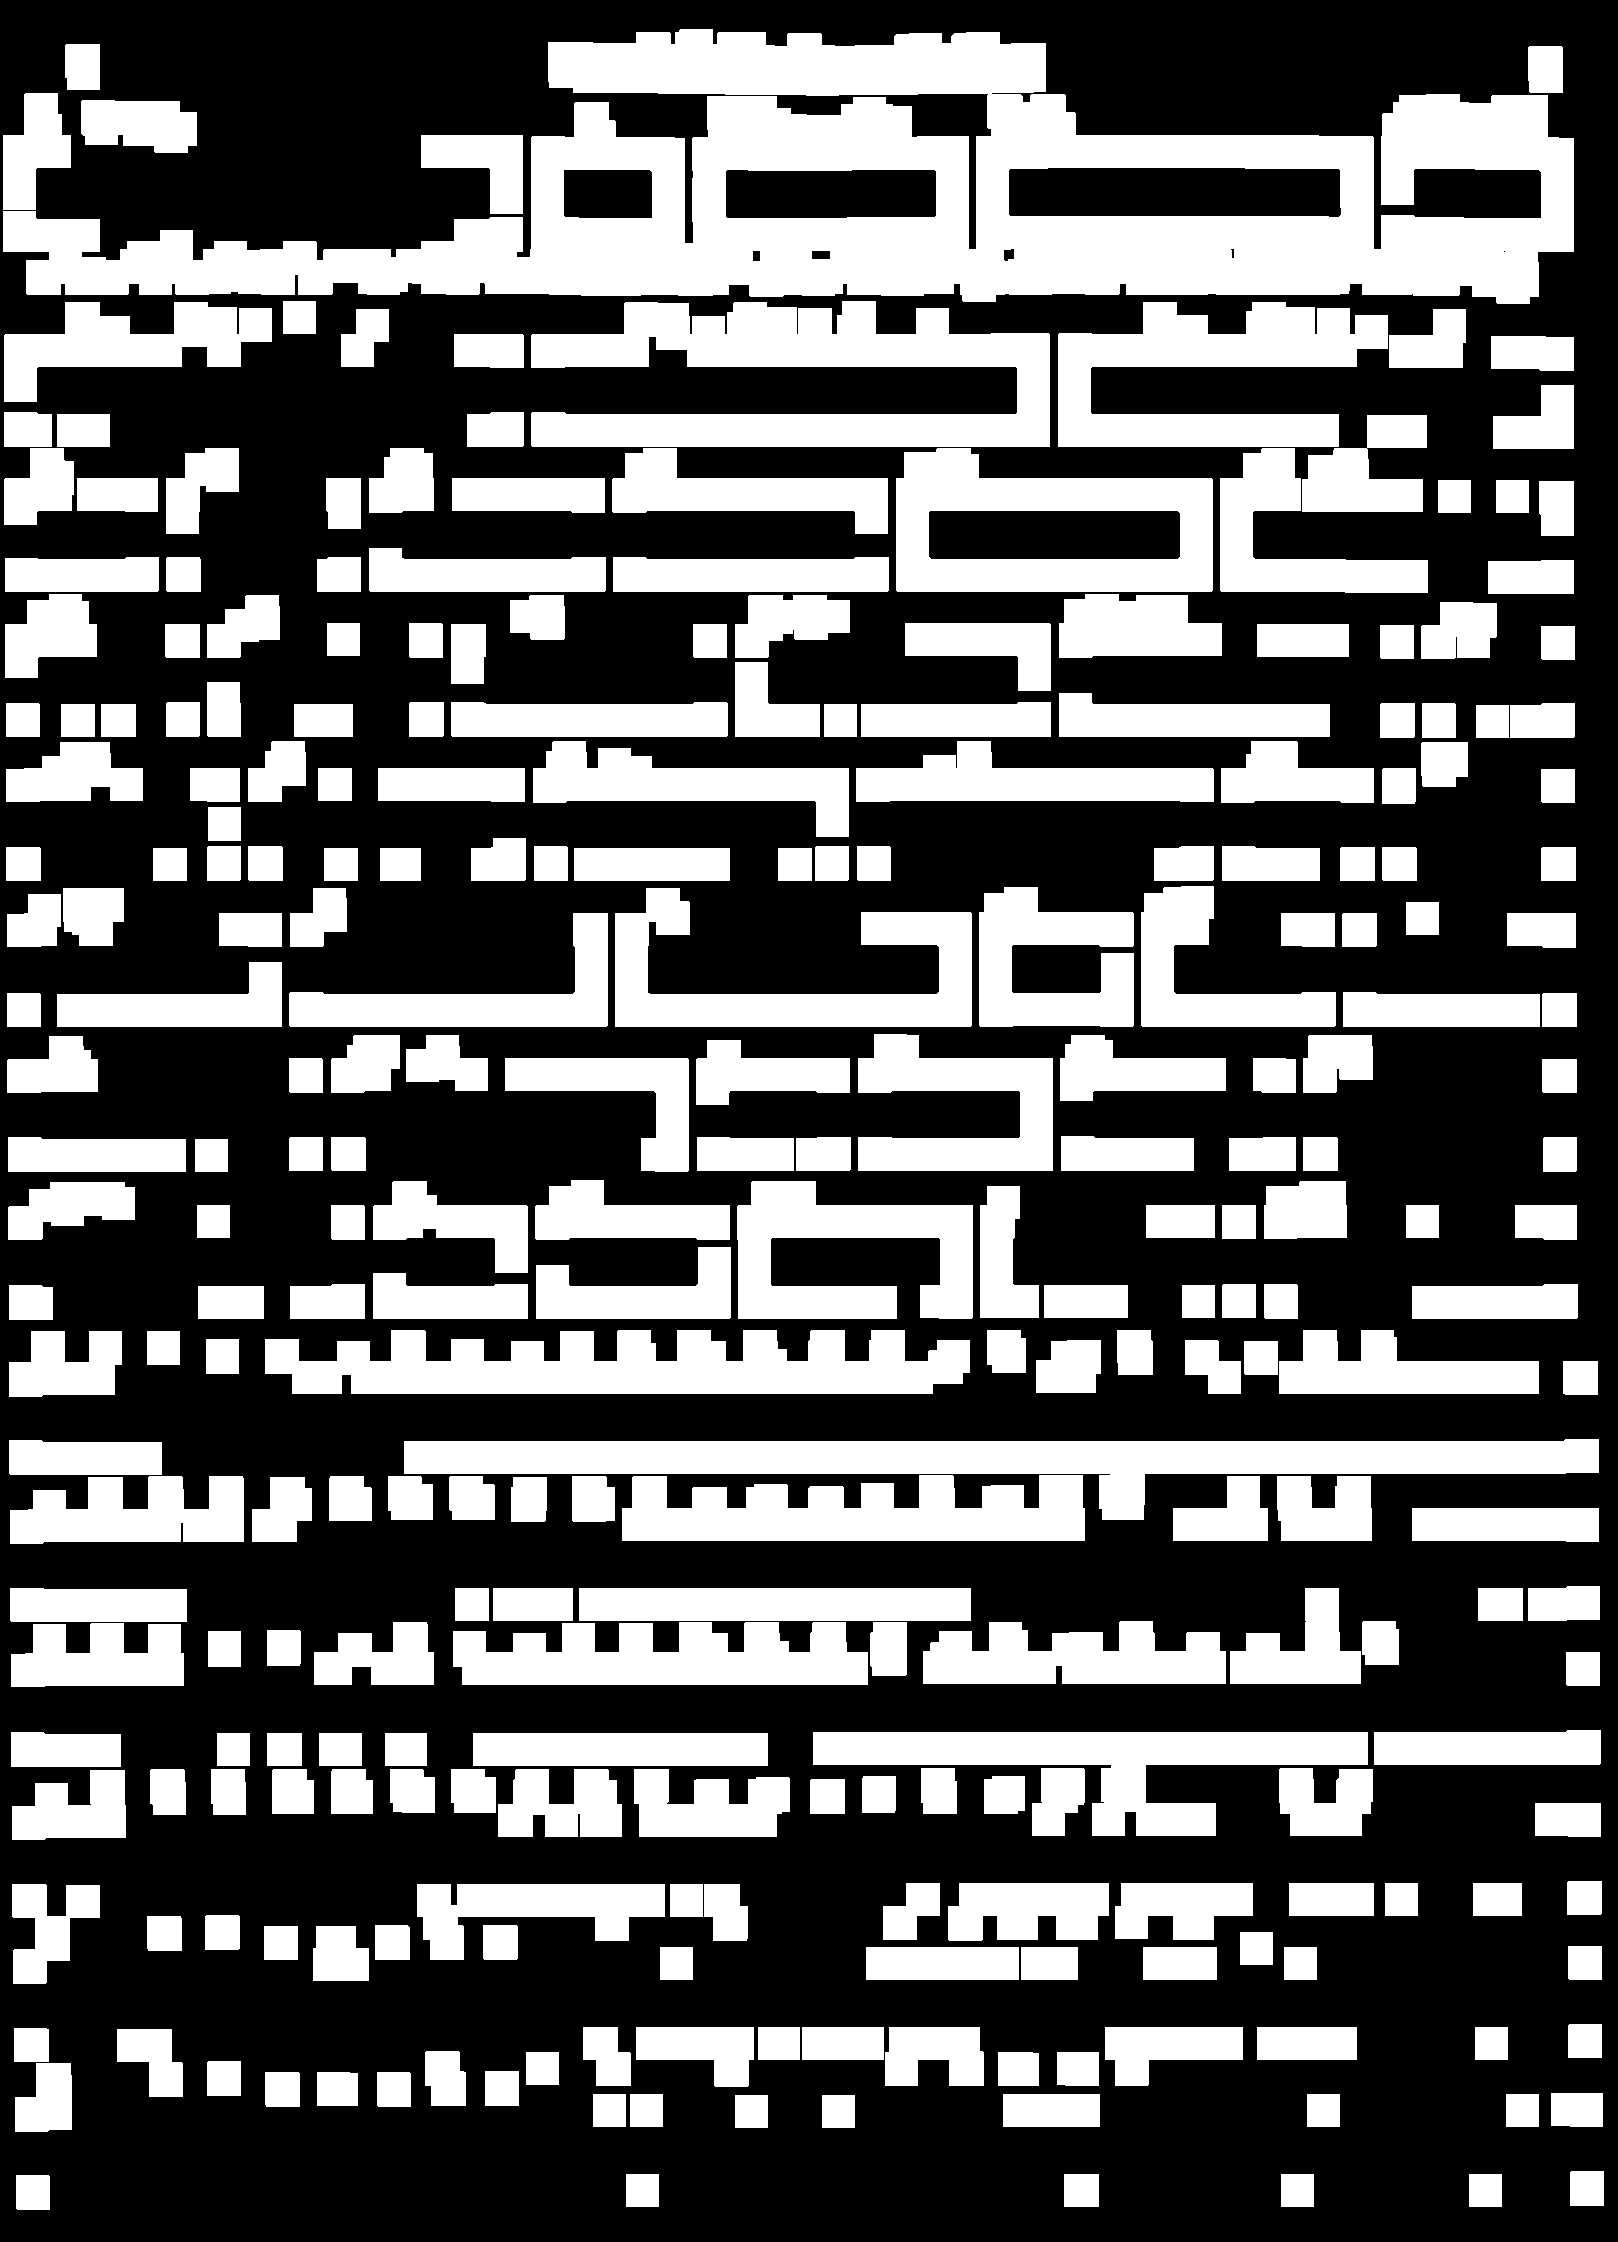

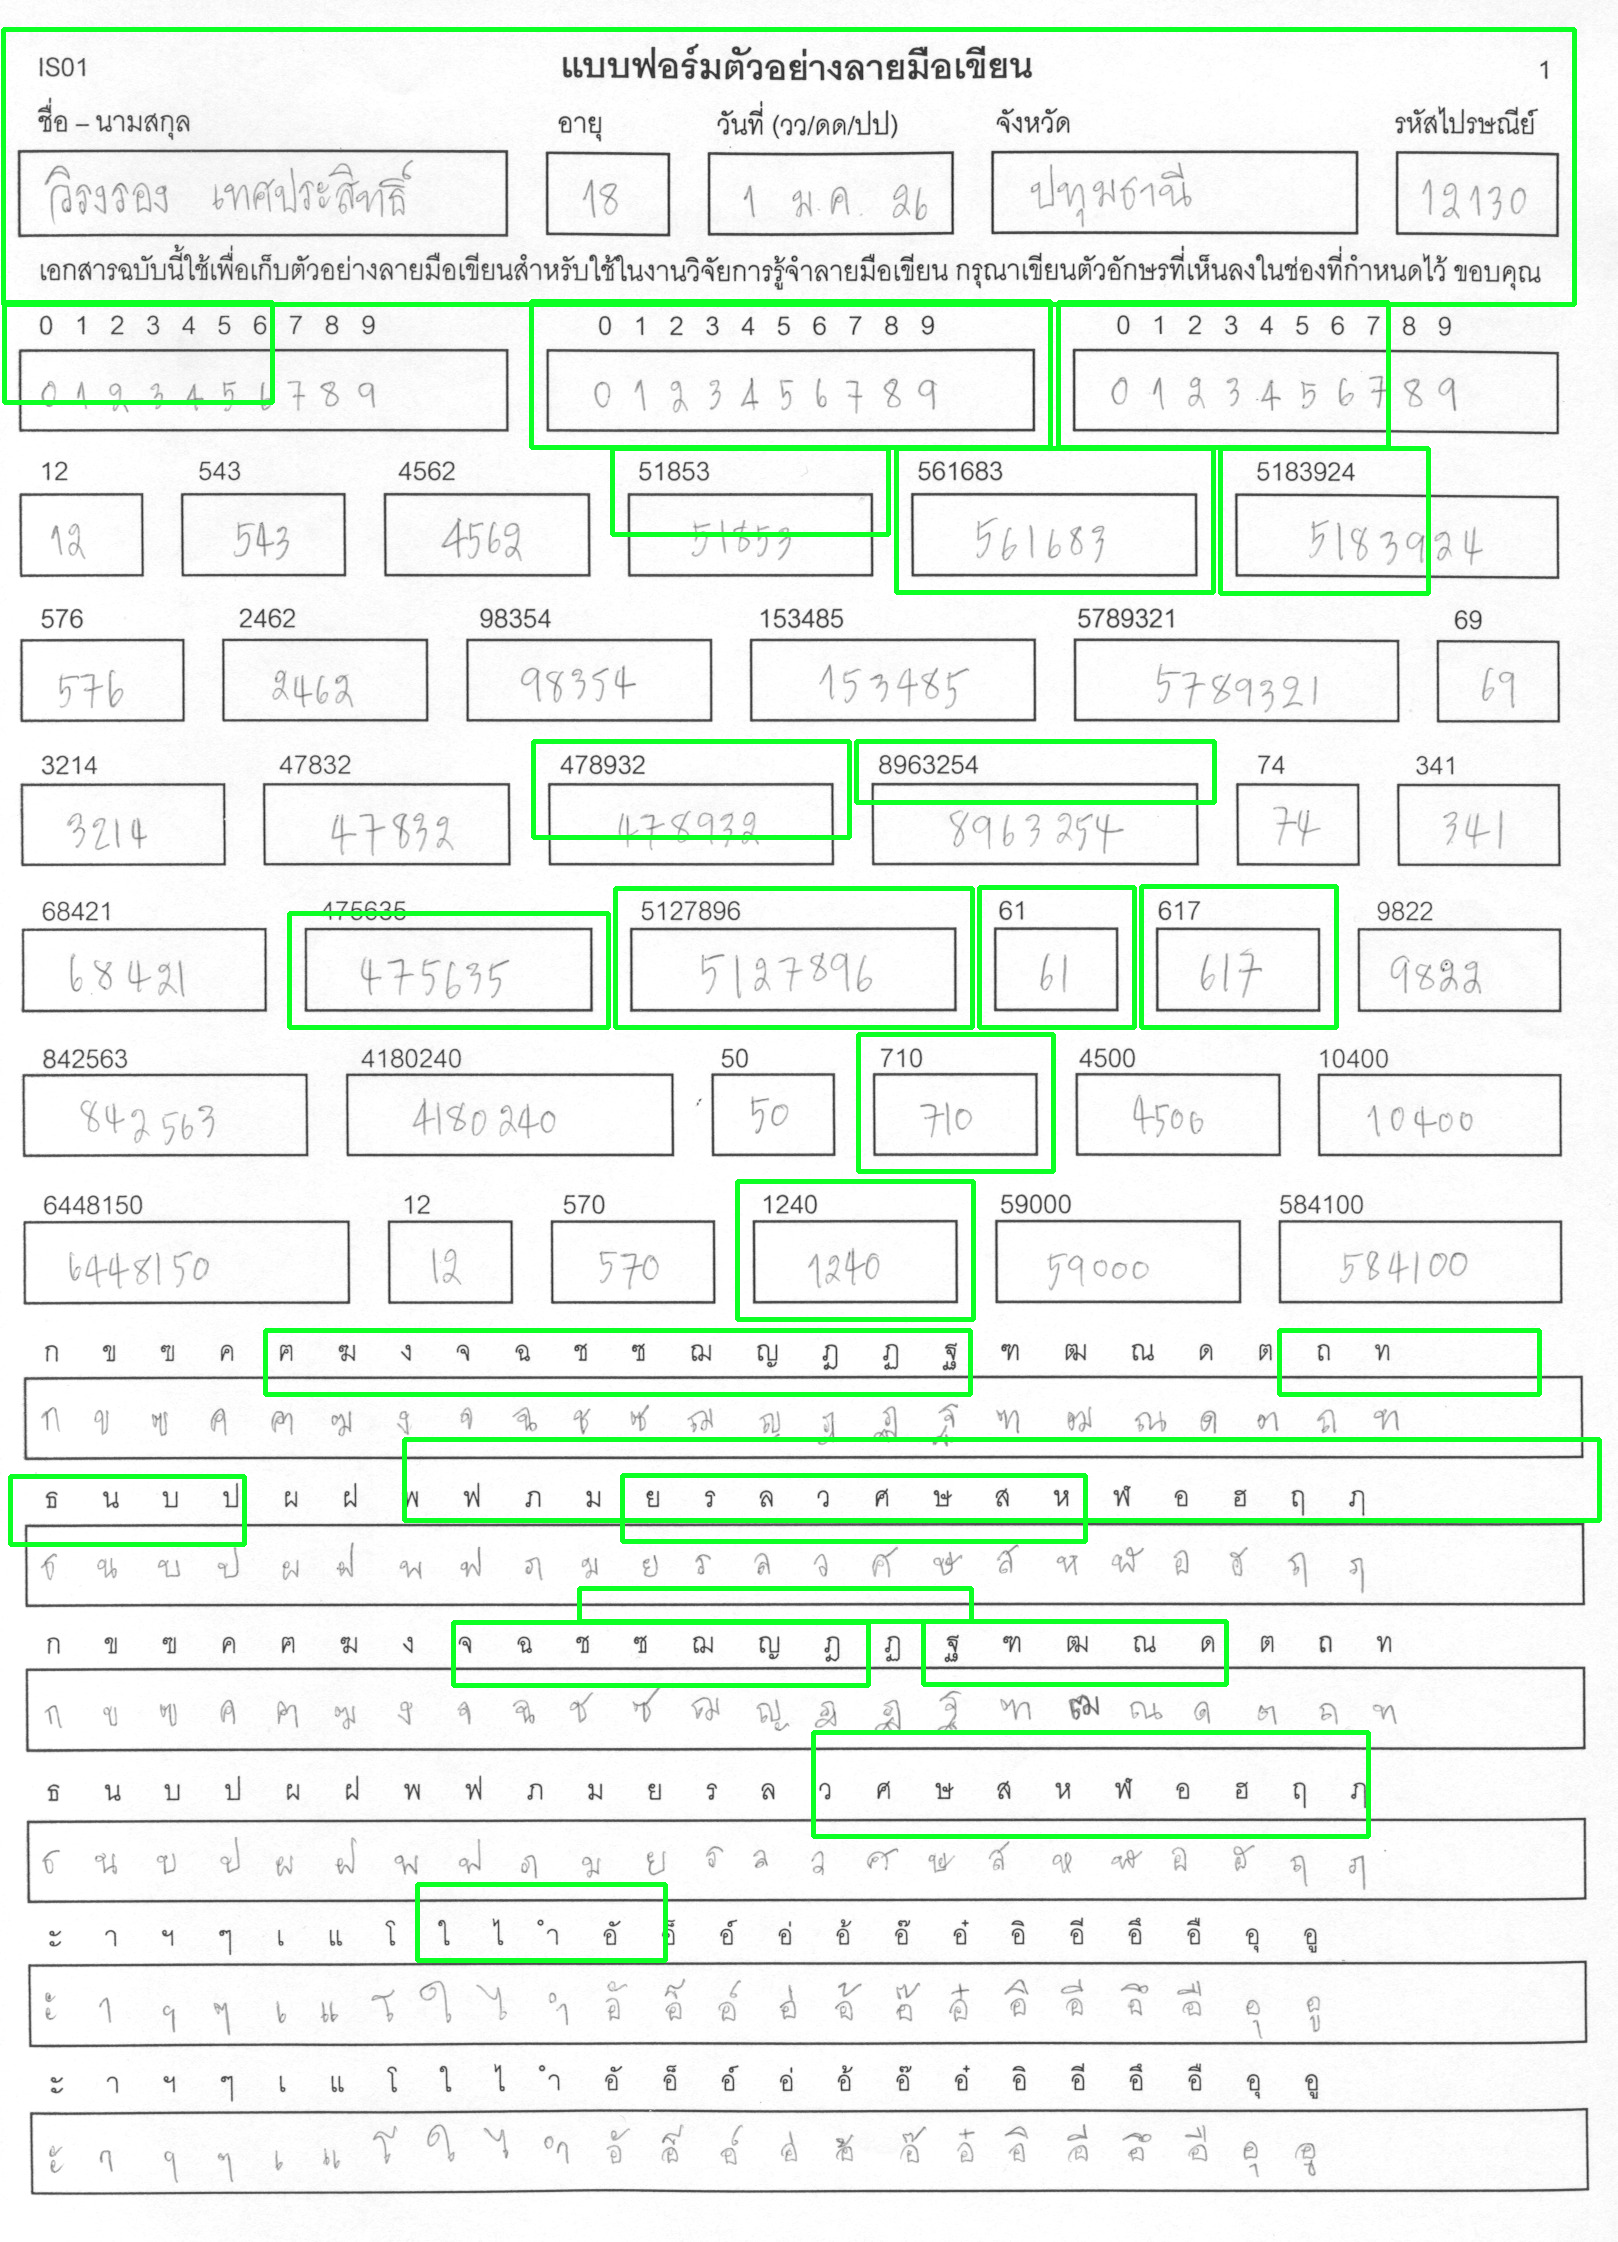

-1

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# Load image, grayscale, Gaussian blur, adaptive threshold
image = cv2.imread('/content/SodaPDF-converted-is01001.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (9,9), 0)
thresh = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,11,30)

# Dilate to combine adjacent text contours
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))
dilate = cv2.dilate(thresh, kernel, iterations=4)

# Find contours, highlight text areas, and extract ROIs
cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

ROI_number = 0
for c in cnts:
    area = cv2.contourArea(c)
    if area > 10000:
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 3)
        # ROI = image[y:y+h, x:x+w]
        # cv2.imwrite('ROI_{}.png'.format(ROI_number), ROI)
        # ROI_number += 1

cv2_imshow(thresh)
cv2_imshow(dilate)
cv2_imshow(image)
cv2.waitKey()

In [ ]:
img =  cv2.imread('/content/SodaPDF-converted-is01001.jpg')
img.shape[:2]

(2242, 1618)

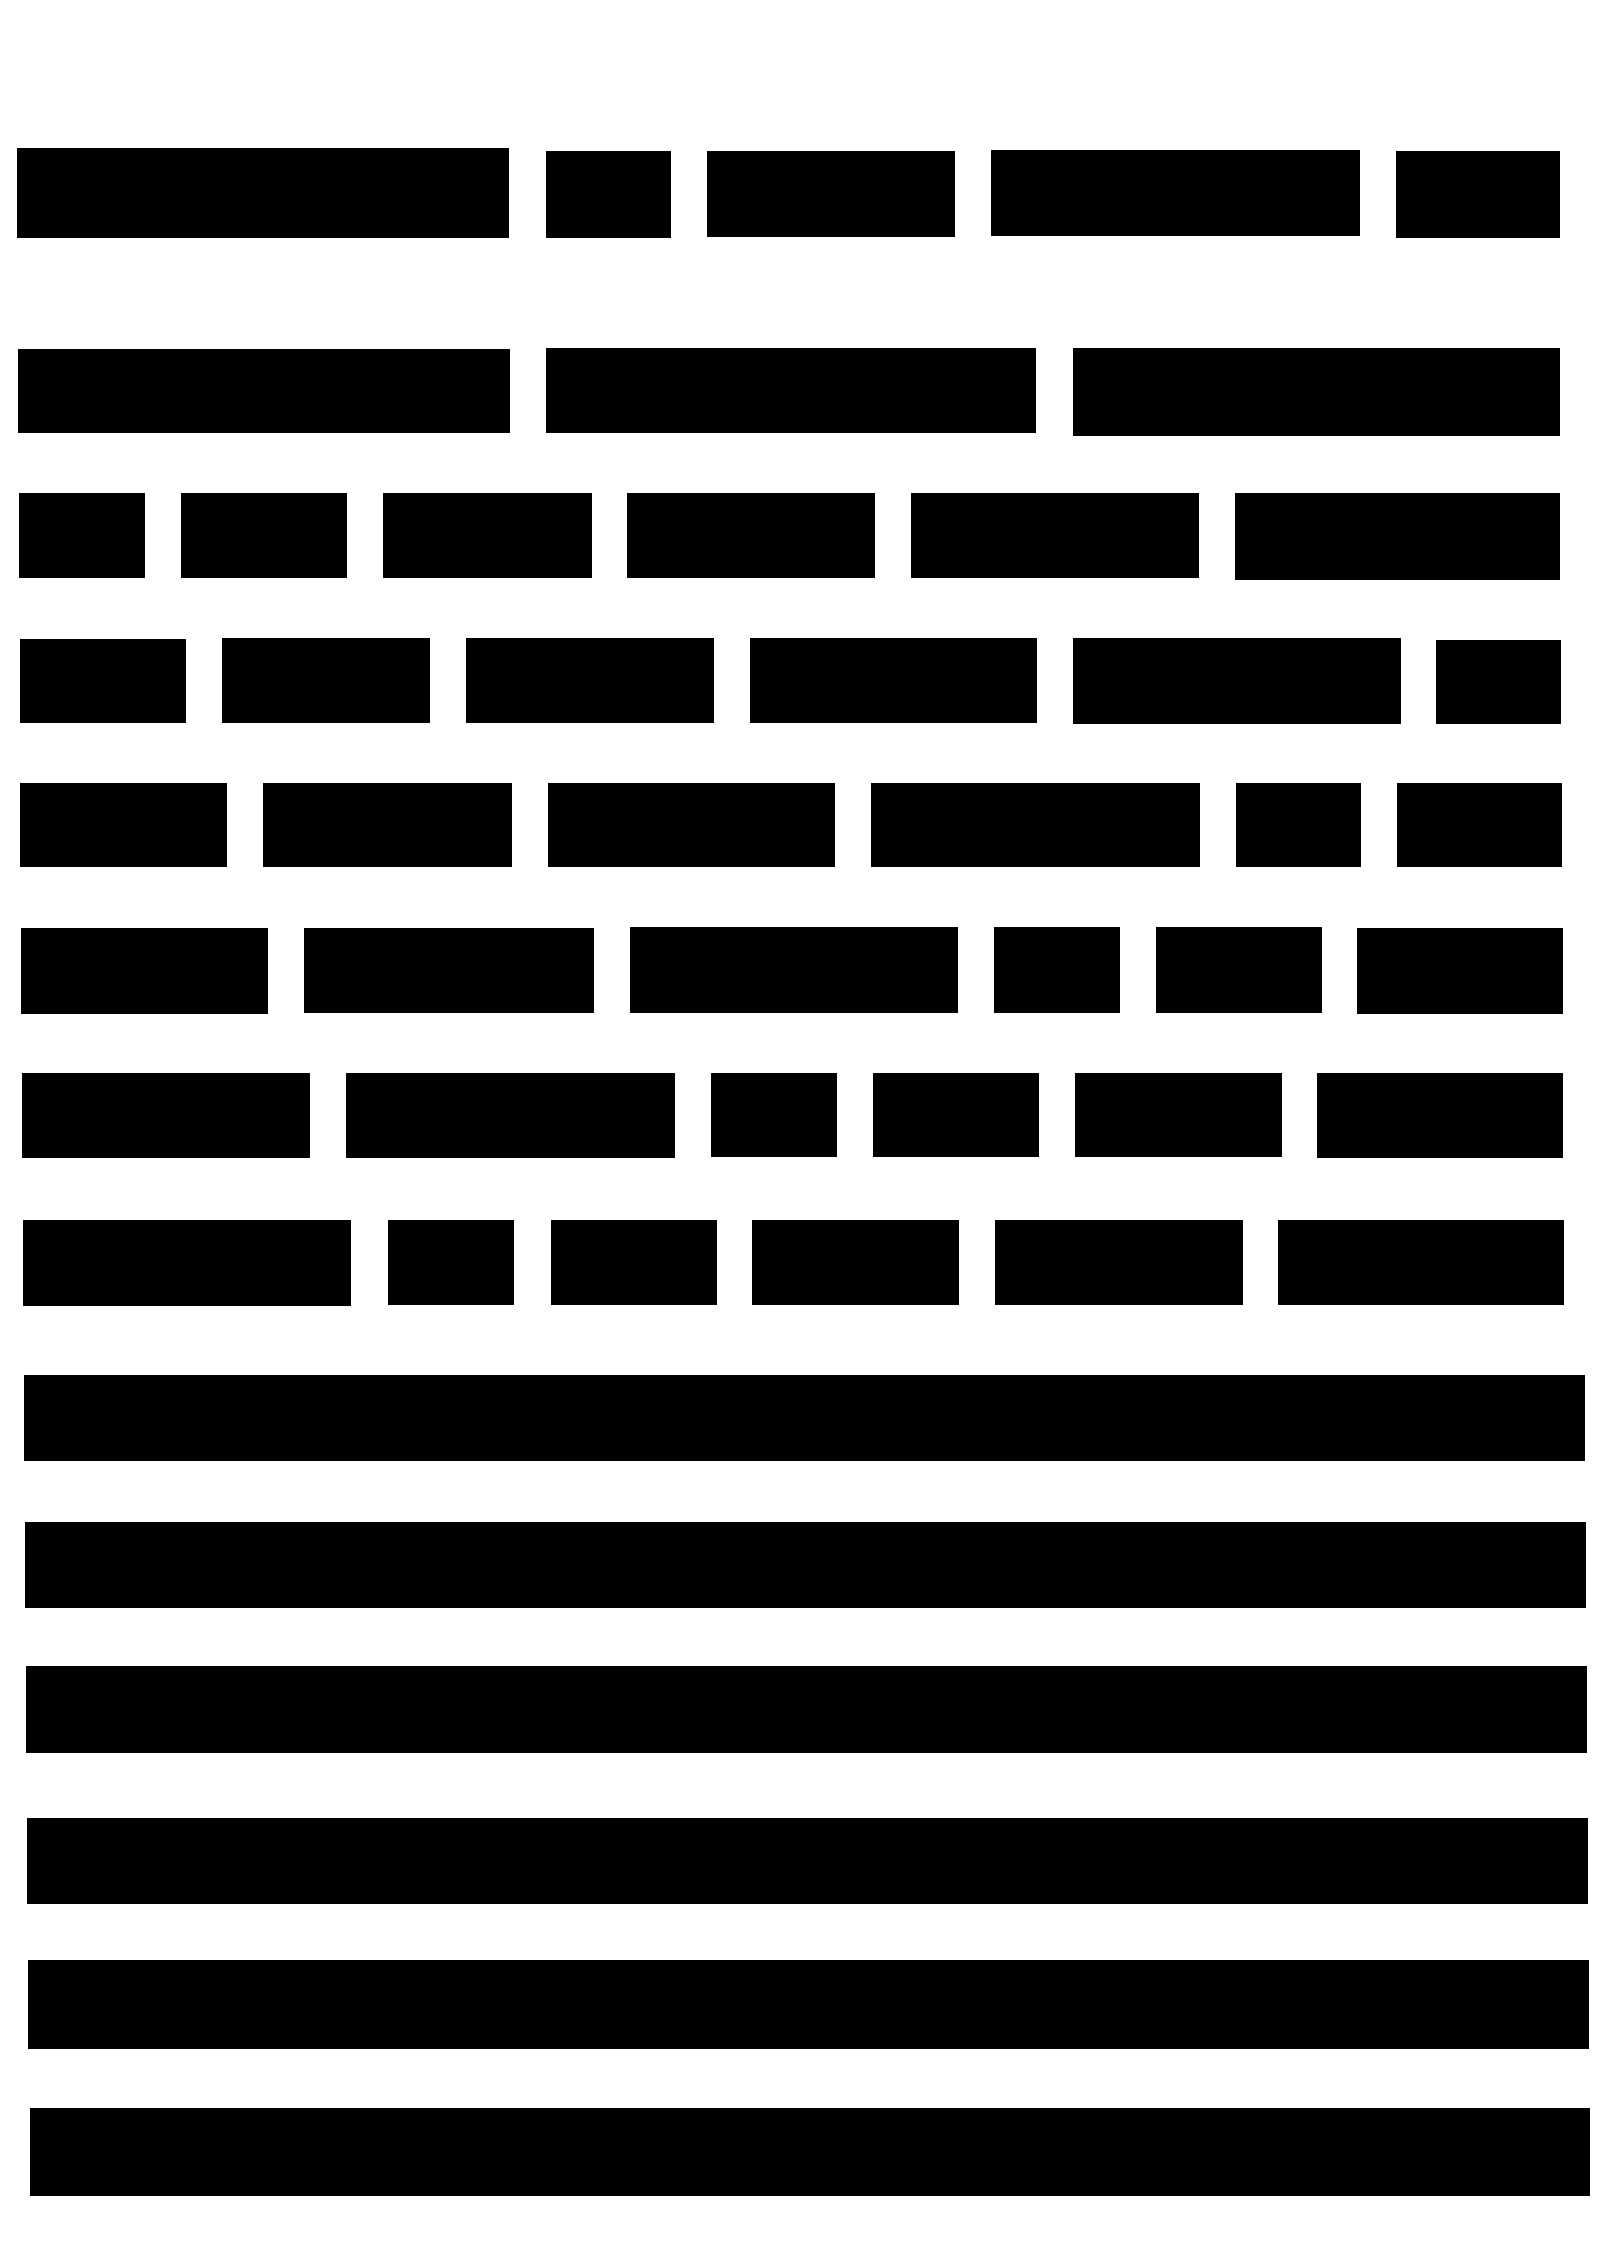

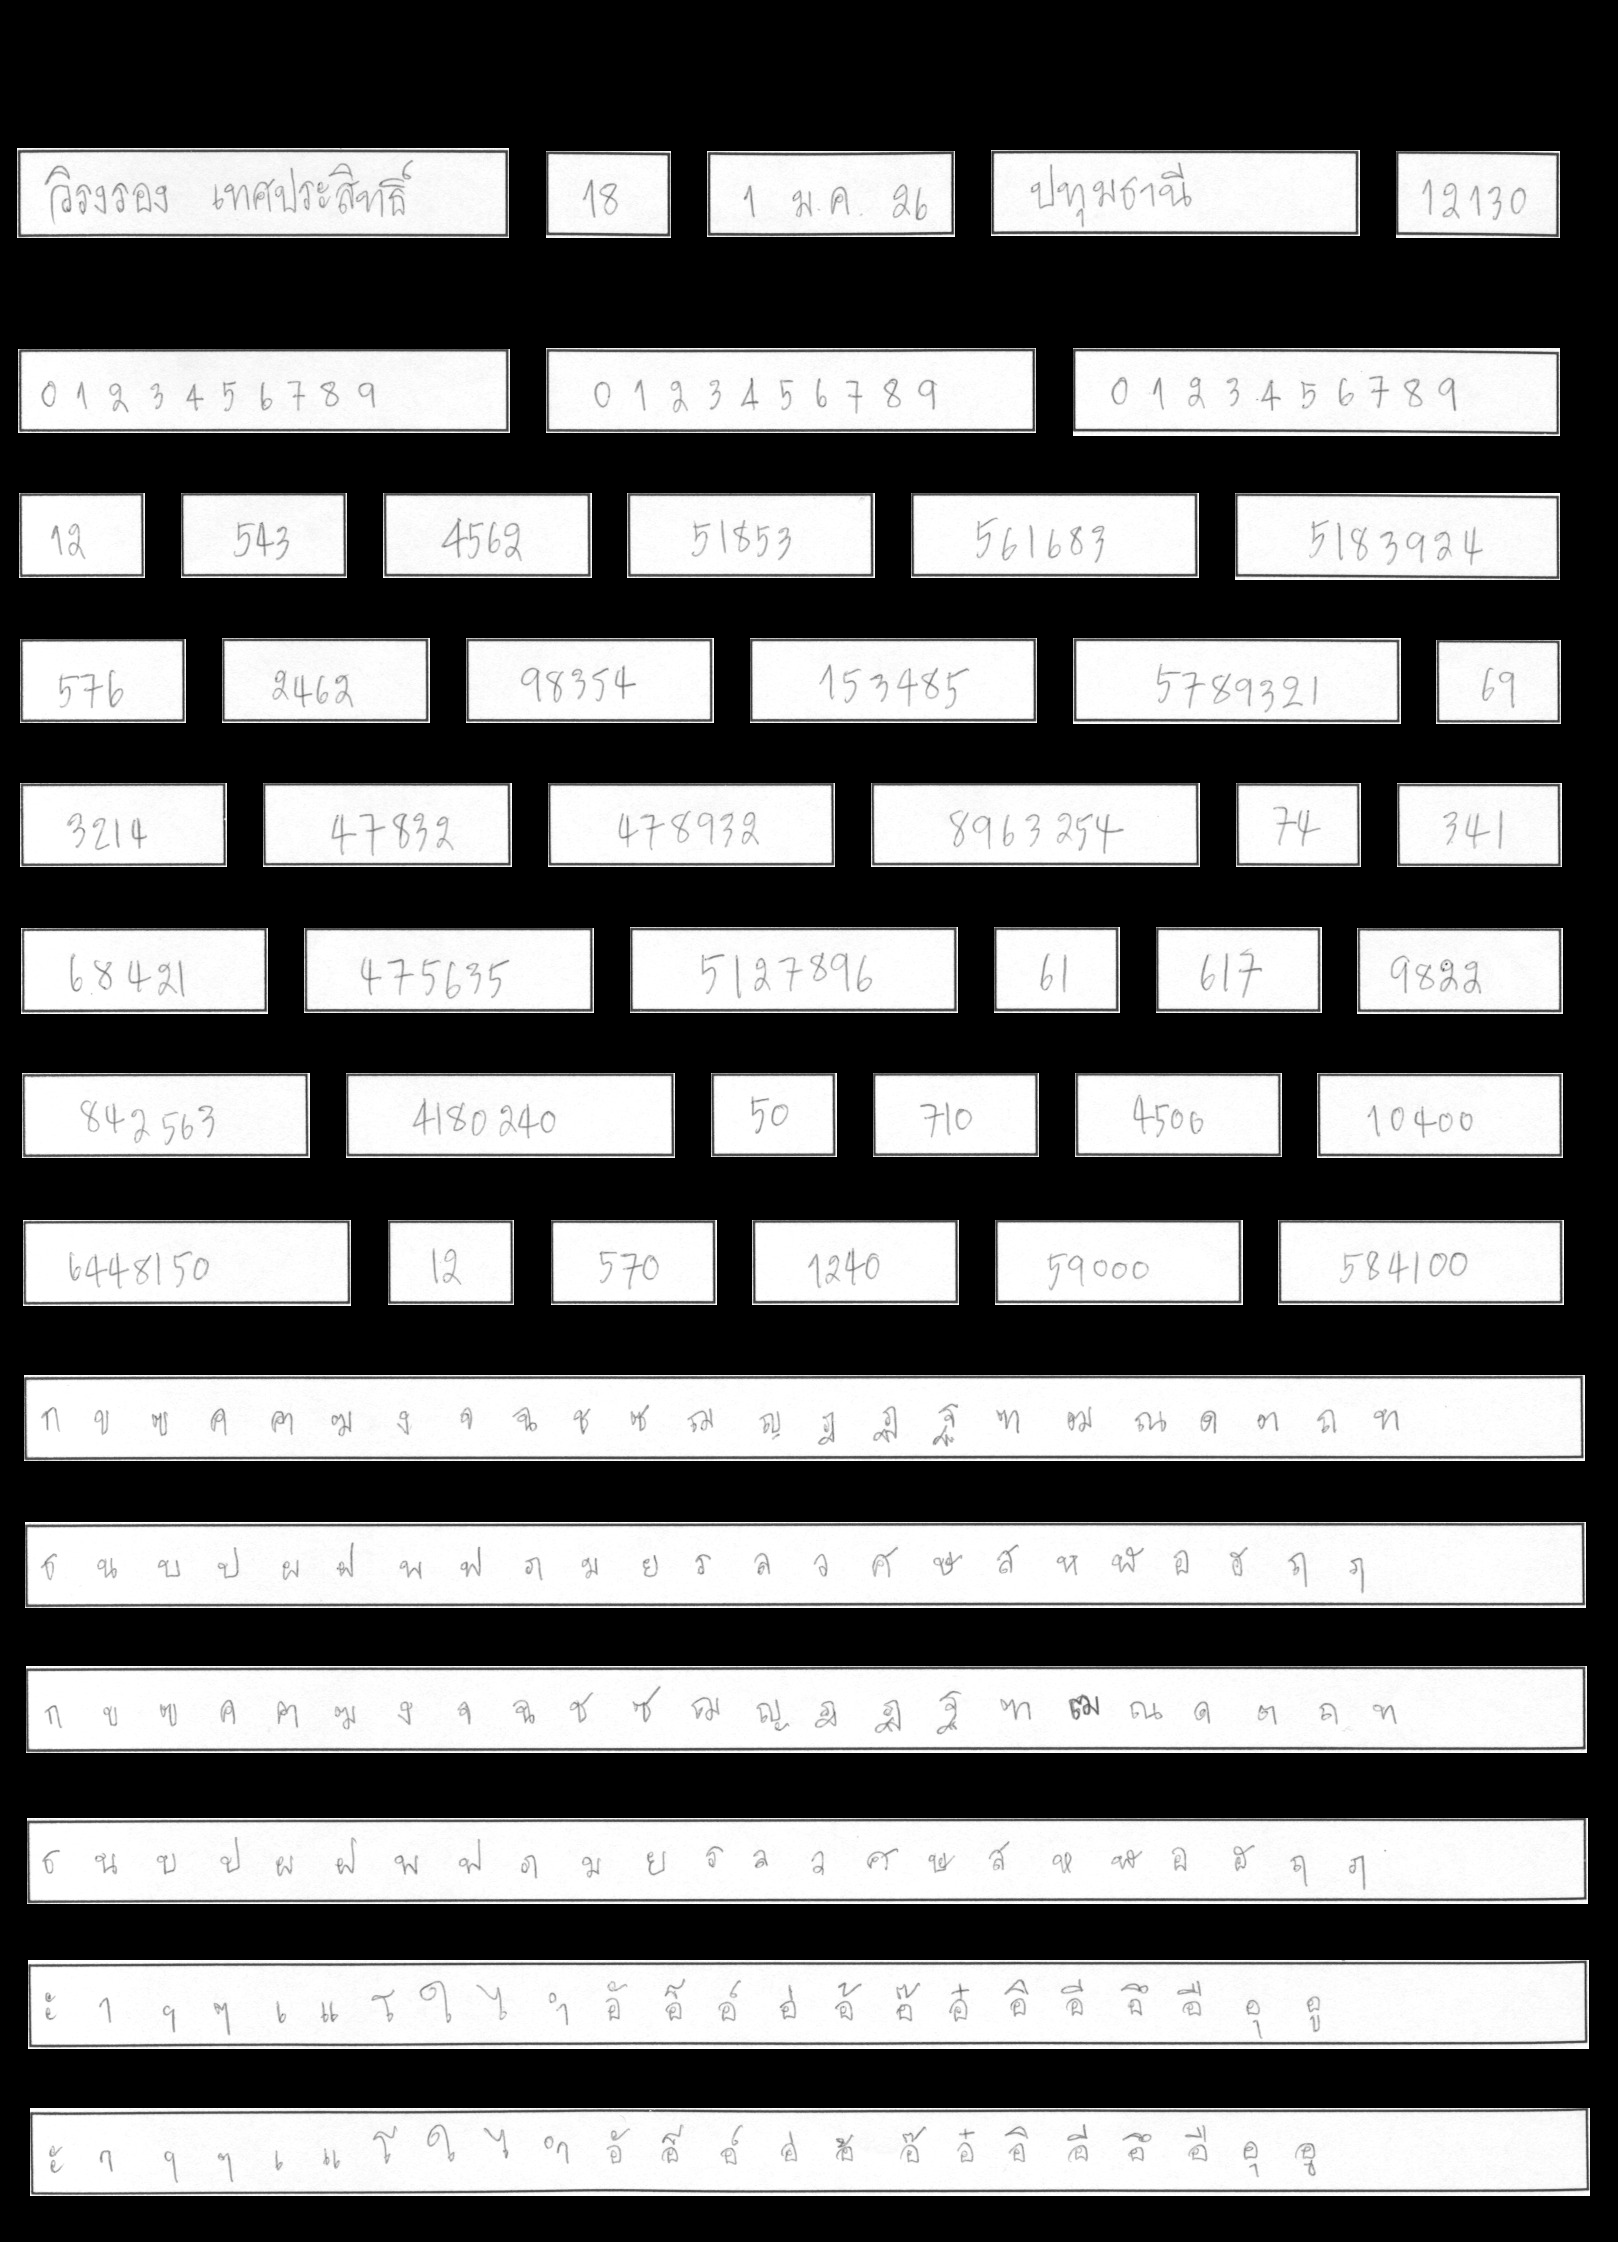

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

img =  cv2.imread('/content/SodaPDF-converted-is01001.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

thresh_inv = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]

# Blur the image
blur = cv2.GaussianBlur(thresh_inv,(1,1),0)

thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

# find contours
contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

ROI_number = 0
mask = np.ones(img.shape[:2], dtype="uint8") * 255
for c in contours:
    # get the bounding rect
    x, y, w, h = cv2.boundingRect(c)
    if w*h>1000:
        cv2.rectangle(mask, (x, y), (x+w, y+h), (0, 0, 255), -1)
        ROI = image[y:y+h, x:x+w]
        cv2.imwrite('ROI_{}.png'.format(ROI_number), ROI)
        ROI_number += 1

res_final = cv2.bitwise_and(img, img, mask=cv2.bitwise_not(mask))

cv2_imshow(mask)
cv2_imshow(res_final)
cv2.waitKey(0)
cv2.destroyAllWindows()